# SETUP

In [4]:
%%capture
# !pip install xarray
# !pip install netcdf4
# !pip install collections
# !pip install scikit-image
# !pip install pysteps
# !pip install cartopy
# !pip install pysteps

In [5]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [6]:
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [7]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy


from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from functools import partial
from abc import abstractmethod
from skimage.transform import rescale

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, SR_BC_GFDL_Dataset_256

# validation

In [8]:
bs_valid = 1400

In [9]:
"""
sr_gfdl_ds = SR_BC_GFDL_Dataset_256("data/1000_gfdl_sr_imagen_e80_19_03.pth")
sr_gfdl_dl = data.DataLoader(sr_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_gfdl = next(iter(sr_gfdl_dl)).cpu()
print("SR GFDL:",dm_sr_gfdl.shape)
"""

'\nsr_gfdl_ds = SR_BC_GFDL_Dataset_256("data/1000_gfdl_sr_imagen_e80_19_03.pth")\nsr_gfdl_dl = data.DataLoader(sr_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)\n\ndm_sr_gfdl = next(iter(sr_gfdl_dl)).cpu()\nprint("SR GFDL:",dm_sr_gfdl.shape)\n'

In [10]:
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

qm_gfdl_ds = QM_GFDL_LR_Dataset_256('data/11_01_deltaQM_debiased_gfdl_valid_custom_dl.pth' )    # this is used for inference
qm_gfdl_dl = data.DataLoader(qm_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

qm_gfdl = next(iter(qm_gfdl_dl)).cpu()
print("QM HR GFDL:",qm_gfdl.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.era5_qm = torch.load(self.path).cpu().numpy()


datasets size torch.Size([1400, 64, 64])
QM HR GFDL: torch.Size([1400, 1, 256, 256])


In [11]:
qm_gfdl_ds_b = SR_BC_GFDL_Dataset_256('data/QM_hr_debiased_gfdl_valid_clip_0.pth')    # this is used for benchmark
qm_gfdl_dl_b = data.DataLoader(qm_gfdl_ds_b, batch_size=bs_valid,shuffle=False, drop_last=True)

qm_gfdl_b = next(iter(qm_gfdl_dl_b)).unsqueeze(1).cpu()
print("HR QM GFDL (benchmark):",qm_gfdl_b.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1400, 256, 256])
HR QM GFDL (benchmark): torch.Size([1400, 1, 256, 256])


In [12]:
era5_lr_ds = era5_upscaled_1d_256(stage='valid')

era5_lr_dl = data.DataLoader(era5_lr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_lr = next(iter(era5_lr_dl))
print("LR ERA5", era5_lr.shape)

LR ERA5 torch.Size([1400, 1, 256, 256])


In [13]:
era5_hr_ds = era5_0_25d_256(stage='valid')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_hr = next(iter(era5_hr_dl))
print("HR ERA5", era5_hr.shape)

HR ERA5 torch.Size([1400, 1, 256, 256])


In [14]:
gfdl_256_ds = gfdl_eval_256(stage='valid')
gfdl_256_dl = data.DataLoader(gfdl_256_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

gfdl_256 = next(iter(gfdl_256_dl))
print("HR original GFDL", gfdl_256.shape)

HR original GFDL torch.Size([1400, 1, 256, 256])


In [15]:
era5_hr_ds = era5_0_25d_256(stage='valid')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)
era5_hr_val = next(iter(era5_hr_dl))
print("HR ERA5 val", era5_hr_val.shape)

HR ERA5 val torch.Size([1400, 1, 256, 256])


In [16]:
dm_hr_era5_ds = SR_BC_GFDL_Dataset_256('data/100_era5_val_sr_imagen_20_09.pth')
dm_hr_era5_dl = data.DataLoader(dm_hr_era5_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

dm_hr_era5 = next(iter(dm_hr_era5_dl))
print("HR DM corrected LR ERA5 val",dm_hr_era5.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1420, 1, 256, 256])
HR DM corrected LR ERA5 val torch.Size([1400, 1, 256, 256])


# for revision

In [17]:
dm_ssp585_ds = SR_BC_GFDL_Dataset_256('data/revision_ssp585_3220_qm_e100_17_09.pth') 
dm_ssp585_dl = data.DataLoader(dm_ssp585_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_ssp = next(iter(dm_ssp585_dl)).cpu()
dm_sr_ssp = era5_hr_ds.inverse_dwd_trafo(dm_sr_ssp)

print("SR SSP585 GFDL (n=50)",dm_sr_ssp.shape)

dataset size torch.Size([3220, 1, 256, 256])
SR SSP585 GFDL (n=50) torch.Size([1400, 1, 256, 256])


In [18]:
dm_sr_no_qm_ds = SR_BC_GFDL_Dataset_256('data/revision_no_qm_gfdl_sr_imagen_100step_e100_17_09.pth') 
dm_sr_no_qm_dl = data.DataLoader(dm_sr_no_qm_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_no_qm = next(iter(dm_sr_no_qm_dl)).cpu()
dm_sr_no_qm = era5_hr_ds.inverse_dwd_trafo(dm_sr_no_qm)

print("SR GFDL no QM",dm_sr_no_qm.shape)

dataset size torch.Size([1420, 1, 256, 256])
SR GFDL no QM torch.Size([1400, 1, 256, 256])


In [19]:
dm_sr_no_noise_ds = SR_BC_GFDL_Dataset_256('data/revision_100_no_nosie_e100_19_09.pth') 
dm_sr_no_noise_dl = data.DataLoader(dm_sr_no_noise_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_no_noise = next(iter(dm_sr_no_noise_dl)).cpu()
dm_sr_no_noise = era5_hr_ds.inverse_dwd_trafo(dm_sr_no_noise)

print("SR GFDL noise lvl 0",dm_sr_no_noise.shape)

dataset size torch.Size([1400, 1, 256, 256])
SR GFDL noise lvl 0 torch.Size([1400, 1, 256, 256])


In [20]:
dm_sr_train_100_ds = SR_BC_GFDL_Dataset_256('data/100_gfdl_sr_imagen_e100_6_09.pth') 
dm_sr_train_100_dl = data.DataLoader(dm_sr_train_100_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_train_100 = next(iter(dm_sr_train_100_dl)).cpu()
dm_sr_train_100 = era5_hr_ds.inverse_dwd_trafo(dm_sr_train_100)

print("SR GFDL noise lvl 50",dm_sr_train_100.shape)

dataset size torch.Size([1400, 1, 256, 256])
SR GFDL noise lvl 50 torch.Size([1400, 1, 256, 256])


In [21]:
dm_sr_n80_ds = SR_BC_GFDL_Dataset_256('data/revision_gfdl_sr_noise_80_i100_e100_18_09.pth') 
dm_sr_n80_dl = data.DataLoader(dm_sr_n80_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

dm_sr_n80 = next(iter(dm_sr_n80_dl)).cpu()
dm_sr_n80 = era5_hr_ds.inverse_dwd_trafo(dm_sr_n80)

print("SR GFDL noise lvl 80 ",dm_sr_n80.shape)

dataset size torch.Size([1400, 1, 256, 256])
SR GFDL noise lvl 80  torch.Size([1400, 1, 256, 256])


# Paper revision

## Plot absolute errors gfdl

In [22]:
#### bias in time + average bias in time (averaged over space) ####   x->256x256(t bias) -> 1 (avg t bias)

#avg_sr_gfdl = torch.mean(era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl[:,:,:,:]).squeeze(1), axis=0)
avg_era5 = torch.mean(era5_hr_ds.inverse_dwd_trafo(era5_hr[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl = torch.mean(gfdl_256_ds.inverse_dwd_trafo(gfdl_256[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl_qm = torch.mean(qm_gfdl_b[:,:,:,:].squeeze(1), axis=0)


#mean_bias_dm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_sr_gfdl)).item(), 2)
#print("Mean bias DM-corrected GFDL",mean_bias_dm_gfdl)
mean_bias_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_gfdl)).item(), 2)
print("Mean bias GFDL",mean_bias_gfdl)
mean_bias_qm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_gfdl_qm)).item(), 2)
print("Mean bias QM-corrected GFDL",mean_bias_qm_gfdl)

Mean bias GFDL 0.69
Mean bias QM-corrected GFDL 0.26


In [23]:
### revision ###
print("------- revision -------")
avg_dm_sr_n80 = torch.mean(dm_sr_n80[:,:,:,:].squeeze(1), axis=0)
avg_dm_sr_no_noise = torch.mean(dm_sr_no_noise[:,:,:,:].squeeze(1), axis=0)
avg_dm_sr_n50 = torch.mean(dm_sr_train_100[:,:,:,:].squeeze(1), axis=0)
avg_dm_sr_no_qm = torch.mean(dm_sr_no_qm[:,:,:,:].squeeze(1), axis=0)
avg_dm_sr_ssp = torch.mean(dm_sr_ssp[:,:,:,:].squeeze(1), axis=0)


mean_bias_sr_n80 = round(torch.mean(torch.abs(avg_era5 - avg_dm_sr_n80)).item(), 2)
print("Mean bias DM-corrected GFDL noise lvl 80",mean_bias_sr_n80)
mean_bias_sr_no_noise = round(torch.mean(torch.abs(avg_era5 - avg_dm_sr_no_noise)).item(), 2)
print("Mean bias DM-corrected GFDL no noise",mean_bias_sr_no_noise)
mean_bias_sr_n50 = round(torch.mean(torch.abs(avg_era5 - avg_dm_sr_n50)).item(), 2)
print("Mean bias DM-corrected GFDL noise lvl 50",mean_bias_sr_n50)
mean_bias_sr_no_qm = round(torch.mean(torch.abs(avg_era5 - avg_dm_sr_no_qm)).item(), 2)
print("Mean bias DM-corrected GFDL no QM",mean_bias_sr_no_qm)
mean_bias_sr_ssp = round(torch.mean(torch.abs(avg_era5 - avg_dm_sr_ssp)).item(), 2)
print("Mean bias DM-corrected GFDL ssp585",mean_bias_sr_ssp)

------- revision -------
Mean bias DM-corrected GFDL noise lvl 80 0.36
Mean bias DM-corrected GFDL no noise 0.29
Mean bias DM-corrected GFDL noise lvl 50 0.29
Mean bias DM-corrected GFDL no QM 0.58
Mean bias DM-corrected GFDL ssp585 0.37


# For paper plot

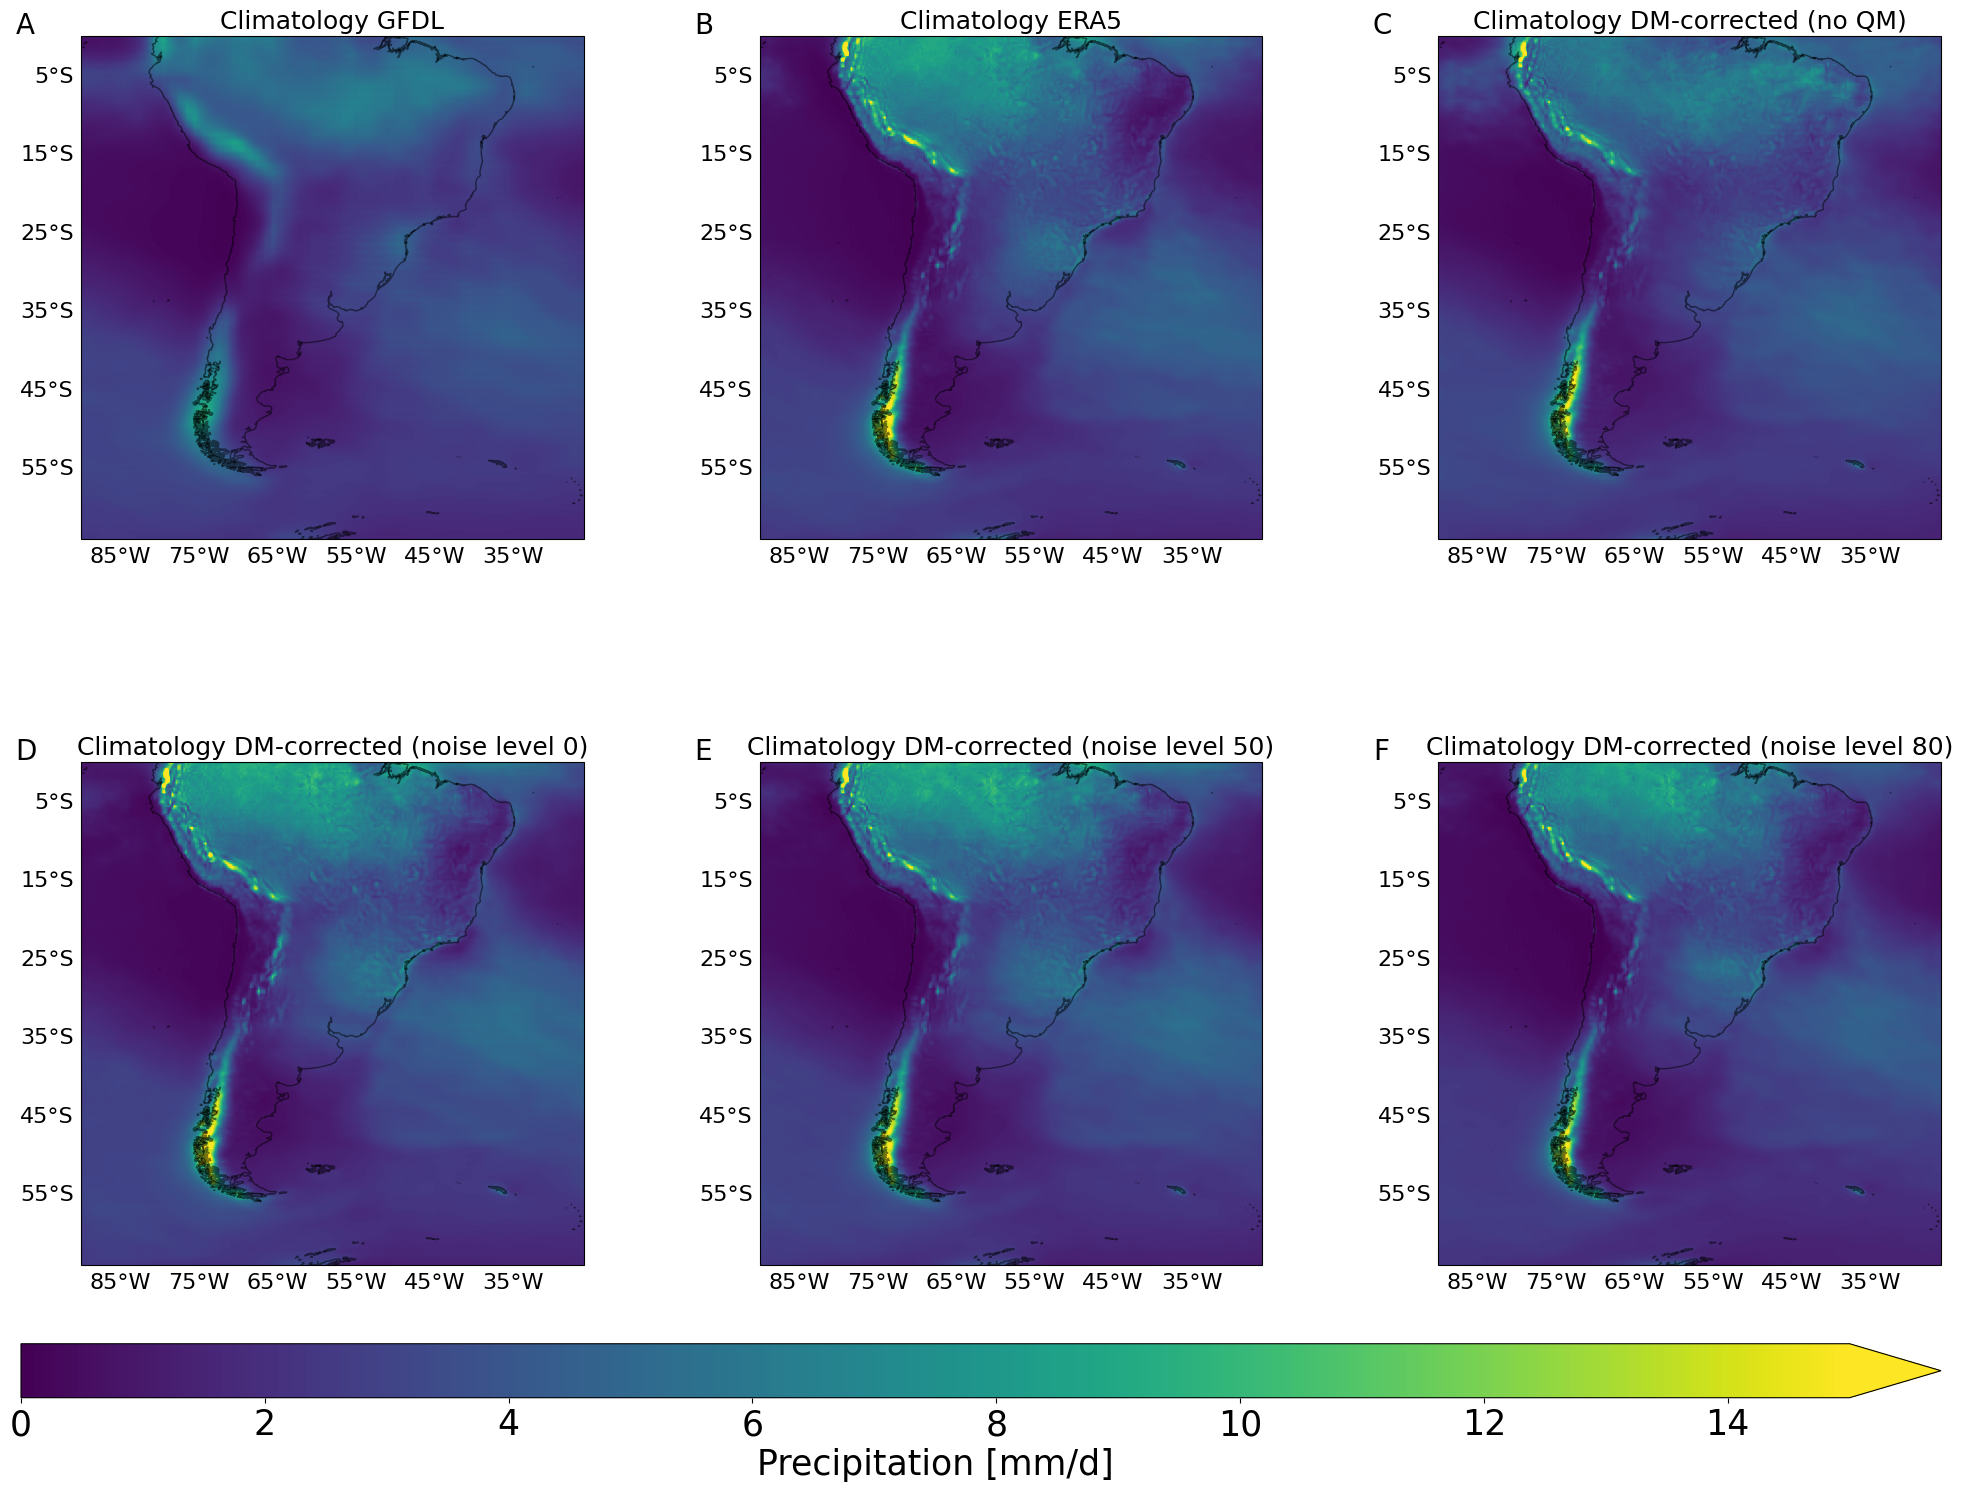

In [26]:
def plot_precipitation(ax, data, title, max_value=3):
    cmap = "viridis" # 'YlGnBu'
    norm = plt.Normalize(vmin=0, vmax=max_value)
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.35, hspace=0.25)

max_value = 15

img1 = plot_precipitation(axes[0,2], avg_dm_sr_no_qm, "", max_value)
axes[0,2].text(-0.13, 1.05, 'C', transform=axes[0,2].transAxes, fontsize=20, fontweight='light', va='top')
axes[0,2].set_title(f'Climatology DM-corrected (no QM)', fontsize=18)

img2 = plot_precipitation(axes[0,0], avg_gfdl, "", max_value)
axes[0,0].text(-0.13, 1.05, 'A', transform=axes[0,0].transAxes, fontsize=20, fontweight='light', va='top')
axes[0,0].set_title(f'Climatology GFDL', fontsize=18)

img3 = plot_precipitation(axes[1,2], avg_dm_sr_n80, "", max_value)
axes[1,2].text(-0.13, 1.05, 'F', transform=axes[1,2].transAxes, fontsize=20, fontweight='light', va='top')
axes[1,2].set_title(f'Climatology DM-corrected (noise level 80)', fontsize=18)


img5 = plot_precipitation(axes[1,0], avg_dm_sr_no_noise, "", max_value)
axes[1,0].text(-0.13, 1.05, 'D', transform=axes[1,0].transAxes, fontsize=20, fontweight='light', va='top')
axes[1,0].set_title(f'Climatology DM-corrected (noise level 0)', fontsize=18)

img6 = plot_precipitation(axes[1,1], avg_dm_sr_n50, "", max_value)
axes[1,1].text(-0.13, 1.05, 'E', transform=axes[1,1].transAxes, fontsize=20, fontweight='light', va='top')
axes[1,1].set_title(f'Climatology DM-corrected (noise level 50)', fontsize=18)

# New plot for SSP
img7 = plot_precipitation(axes[0,1], avg_era5, "", max_value)
axes[0,1].text(-0.13, 1.05, 'B', transform=axes[0,1].transAxes, fontsize=20, fontweight='light', va='top')
axes[0,1].set_title(f'Climatology ERA5', fontsize=18)

# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax_row in axes:
    for ax in ax_row:
        ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
        gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
        gl.xlabel_style = {'size': 16}  
        gl.ylabel_style = {'size': 16}
        
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.03])  # Moved the colorbar up by changing the second parameter to 0.04
cbar = fig.colorbar(img1, cax=cbar_ax, extend="max", orientation="horizontal")
cbar.set_label('Precipitation [mm/d]', fontsize=25)
cbar.ax.tick_params(labelsize=25)

#plt.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.1)

save_figu = False
if save_figu == True:
    plt.savefig("figures_paper/climatologies_revision.pdf")
    print("Saving to figures_paper/climatologies_revision.pdf")
plt.show()

Saving to figures_paper/revision_bias.pdf


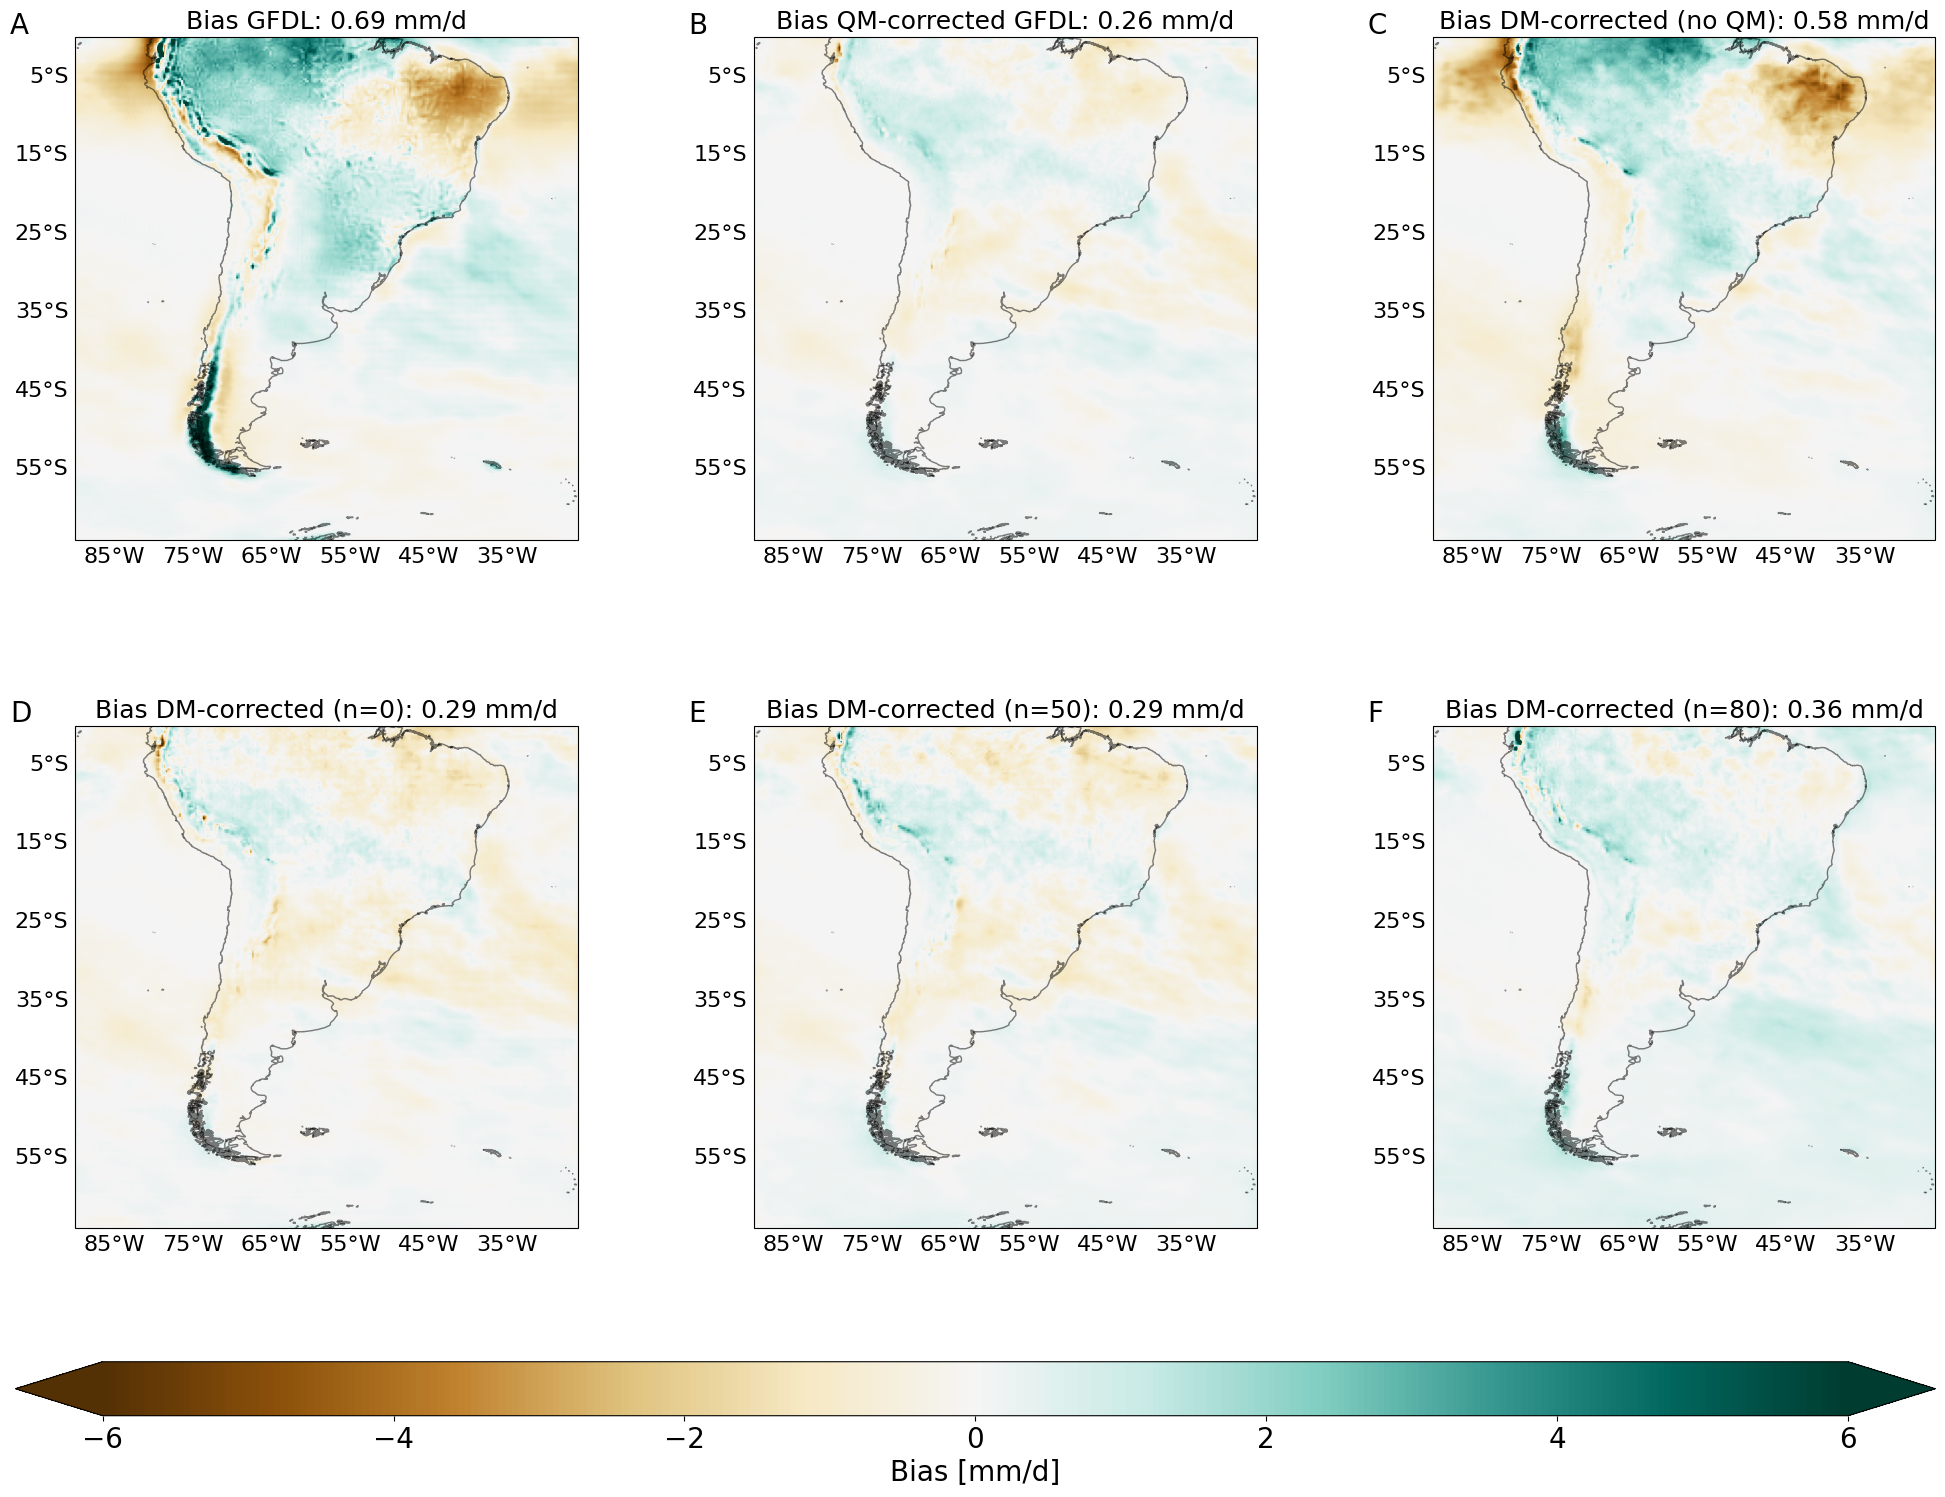

In [27]:
def plot_precipitation(ax, data, title, max_value=3):
    cmap = 'BrBG'
    norm = plt.Normalize(vmin=-max_value, vmax=max_value)
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.35, hspace=0.25)

max_value = 6

# Plotting the precipitation differences
img1 = plot_precipitation(axes[0, 2], avg_era5 - avg_dm_sr_no_qm, "", max_value)
axes[0, 2].text(-0.13, 1.05, 'C', transform=axes[0, 2].transAxes, fontsize=20, fontweight='light', va='top')
axes[0, 2].set_title(f'Bias DM-corrected (no QM): {mean_bias_sr_no_qm} mm/d', fontsize=18)

img2 = plot_precipitation(axes[0, 0], avg_era5 - avg_gfdl, "", max_value)
axes[0, 0].text(-0.13, 1.05, 'A', transform=axes[0, 0].transAxes, fontsize=20, fontweight='light', va='top')
axes[0, 0].set_title(f'Bias GFDL: {mean_bias_gfdl} mm/d', fontsize=18)

img3 = plot_precipitation(axes[1, 2], avg_era5 - avg_dm_sr_n80, "", max_value)
axes[1, 2].text(-0.13, 1.05, 'F', transform=axes[1, 2].transAxes, fontsize=20, fontweight='light', va='top')
axes[1, 2].set_title(f'Bias DM-corrected (n=80): {mean_bias_sr_n80} mm/d', fontsize=18)

img5 = plot_precipitation(axes[1, 0], avg_era5 - avg_dm_sr_no_noise, "", max_value)
axes[1, 0].text(-0.13, 1.05, 'D', transform=axes[1, 0].transAxes, fontsize=20, fontweight='light', va='top')
axes[1, 0].set_title(f'Bias DM-corrected (n=0): {mean_bias_sr_no_noise} mm/d', fontsize=18)

img6 = plot_precipitation(axes[1, 1], avg_era5 - avg_dm_sr_n50, "", max_value)
axes[1, 1].text(-0.13, 1.05, 'E', transform=axes[1, 1].transAxes, fontsize=20, fontweight='light', va='top')
axes[1, 1].set_title(f'Bias DM-corrected (n=50): {mean_bias_sr_n50} mm/d', fontsize=18)

img7 = plot_precipitation(axes[0, 1], avg_era5 - avg_gfdl_qm, "", max_value)
axes[0, 1].text(-0.13, 1.05, 'B', transform=axes[0, 1].transAxes, fontsize=20, fontweight='light', va='top')
axes[0, 1].set_title(f'Bias QM-corrected GFDL: {mean_bias_qm_gfdl} mm/d', fontsize=18)

# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax_row in axes:
    for ax in ax_row:
        ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
        gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
        gl.xlabel_style = {'size': 16}  
        gl.ylabel_style = {'size': 16}

        
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.03])  # Adjust the position of the colorbar here
cbar = fig.colorbar(img1, cax=cbar_ax, extend="both", orientation="horizontal")
cbar.set_label('Bias [mm/d]', fontsize=20)
cbar.ax.tick_params(labelsize=20)  

#plt.tight_layout(pad=4.0)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(hspace=0.1)  

save_figu = True
if save_figu:
    plt.savefig("figures_paper/revision_bias.pdf")
    print("Saving to figures_paper/revision_bias.pdf")
plt.show()